In [32]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pickle
import networkx as nx
from pathlib import Path
from glob import glob
from tqdm import tqdm
from collections import defaultdict

os.getcwd()

from graph_creator.create_graph import get_scenario_data, plot_scene_at_timestep
from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph
from subgraphs.subgraph_types import get_all_subgraphs


# Node Coverage Visualization


In [34]:
repo_root = Path.cwd()
while not (repo_root / ".git").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent

GRAPH_ROOT_ARGOVERSE = repo_root / "actor_graphs" / "argoverse"
GRAPH_ROOT_CARLA = repo_root / "carla_actor_graph_setting_1_50_50_10_20_20_4_4_4" / "carla_actor_graph_setting_1_50_50_10_20_20_4_4_4"
MAX_GRAPHS = 100

In [35]:
actor_graph_paths_argo = sorted(GRAPH_ROOT_ARGOVERSE.glob('*_actor_graph.pkl'))[:MAX_GRAPHS]
actor_graph_paths_carla = sorted(GRAPH_ROOT_CARLA.glob('*actor_graph.pkl'))[:MAX_GRAPHS]

graph_data = []
for actor_graph_path in tqdm(actor_graph_paths_argo, desc="Loading Argoverse graphs"):
    with open(actor_graph_path, "rb") as f:
        actor_graph = pickle.load(f)
    for timestamp, G_nx in actor_graph.actor_graphs.items():
        graph_data.append({
            'dataset': 'argoverse',
            'actor_graph_path': str(actor_graph_path),
            'timestamp': timestamp,
            'graph': G_nx
        })

for actor_graph_path in tqdm(actor_graph_paths_carla, desc="Loading CARLA graphs"):
    with open(actor_graph_path, "rb") as f:
        actor_graph = pickle.load(f)
    for timestamp, G_nx in actor_graph.actor_graphs.items():
        graph_data.append({
            'dataset': 'carla',
            'actor_graph_path': str(actor_graph_path),
            'timestamp': timestamp,
            'graph': G_nx
        })

Loading CARLA graphs: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


In [ ]:
from subgraphs.subgraph_types import get_all_subgraphs, get_simple_patterns, get_complex_patterns

all_patterns = get_all_subgraphs()
simple_patterns = get_simple_patterns()  # For 2-node isolated components
complex_patterns = get_complex_patterns()  # For 3+ node components

node_match = ["actor_type", "lane_change", "is_on_intersection"]
edge_match = ["edge_type"]

node_coverage_data = []

for graph_info in tqdm(graph_data, desc="Counting node coverage (component-based)"):
    dataset = graph_info['dataset']
    actor_graph_path = graph_info['actor_graph_path']
    timestamp = graph_info['timestamp']
    ag_nx = graph_info['graph']
    
    graph_id = f"{actor_graph_path}_{timestamp}"
    
    components = list(nx.weakly_connected_components(ag_nx))
    
    for component_nodes in components:
        component_graph = ag_nx.subgraph(component_nodes).copy()
        num_nodes = len(component_nodes)
        
        if num_nodes == 2:
            # Use simple patterns for isolated 2-node components
            patterns_to_check = simple_patterns
        else:
            patterns_to_check = complex_patterns
        
        for subgraph_name, subgraph_template in patterns_to_check.items():
            GM = nx.algorithms.isomorphism.DiGraphMatcher(
                component_graph, subgraph_template,
                node_match=nx.algorithms.isomorphism.categorical_node_match(
                    node_match, [None] * len(node_match)
                ),
                edge_match=nx.algorithms.isomorphism.categorical_edge_match(
                    edge_match, [None] * len(edge_match)
                )
            )
            
            node_coverage_count = defaultdict(int)
            for mapping in GM.subgraph_isomorphisms_iter():
                for node_id in mapping.keys():
                    node_coverage_count[node_id] += 1
            
            covered_nodes = set(node_coverage_count.keys())
            
            for node_id, count in node_coverage_count.items():
                node_coverage_data.append({
                    'dataset': dataset,
                    'graph_path': graph_id,
                    'actor_graph_path': actor_graph_path,
                    'timestamp': timestamp,
                    'node_id': node_id,
                    'subgraph_name': subgraph_name,
                    'coverage_count': count,
                    'component_size': num_nodes
                })
            
            uncovered_nodes = component_nodes - covered_nodes
            for node_id in uncovered_nodes:
                node_coverage_data.append({
                    'dataset': dataset,
                    'graph_path': graph_id,
                    'actor_graph_path': actor_graph_path,
                    'timestamp': timestamp,
                    'node_id': node_id,
                    'subgraph_name': subgraph_name,
                    'coverage_count': 0,
                    'component_size': num_nodes
                })
    
    all_nodes = set(ag_nx.nodes())
    checked_patterns = set()
    
    for component_nodes in components:
        num_nodes = len(component_nodes)
        if num_nodes == 2:
            checked_patterns.update(simple_patterns.keys())
        else:
            checked_patterns.update(complex_patterns.keys())
    
    unchecked_patterns = set(all_patterns.keys()) - checked_patterns
    for node_id in all_nodes:
        for pattern_name in unchecked_patterns:
            node_coverage_data.append({
                'dataset': dataset,
                'graph_path': graph_id,
                'actor_graph_path': actor_graph_path,
                'timestamp': timestamp,
                'node_id': node_id,
                'subgraph_name': pattern_name,
                'coverage_count': 0,
                'component_size': None  # Pattern not applicable
            })

coverage_df = pd.DataFrame(node_coverage_data)



Counting node coverage (component-based): 100%|██████████| 2600/2600 [00:25<00:00, 102.14it/s]



✅ Component-based analysis complete!
   Total patterns: 18 (Simple: 3, Complex: 15)


In [37]:

# Group by node (across all patterns) to see if node has any coverage
node_level_df = coverage_df.groupby(['dataset', 'graph_path', 'node_id']).agg({
    'coverage_count': 'sum'  # Total coverage across all patterns
}).reset_index()

# Calculate coverage by dataset
for dataset_name in ['argoverse', 'carla']:
    dataset_nodes = node_level_df[node_level_df['dataset'] == dataset_name]
    total_nodes = len(dataset_nodes)
    covered_nodes = (dataset_nodes['coverage_count'] > 0).sum()
    uncovered_nodes = total_nodes - covered_nodes
    
    coverage_pct = 100 * covered_nodes / total_nodes if total_nodes > 0 else 0
    
    print(f"\n{dataset_name.upper()}:")
    print(f"  Total nodes: {total_nodes:,}")
    print(f"  Covered nodes (≥1 match): {covered_nodes:,} ({coverage_pct:.1f}%)")
    print(f"  Uncovered nodes: {uncovered_nodes:,} ({100-coverage_pct:.1f}%)")

# Overall coverage
total_nodes = len(node_level_df)
covered_nodes = (node_level_df['coverage_count'] > 0).sum()
uncovered_nodes = total_nodes - covered_nodes
coverage_pct = 100 * covered_nodes / total_nodes

print(f"\nOVERALL:")
print(f"  Total nodes: {total_nodes:,}")
print(f"  Covered nodes (≥1 match): {covered_nodes:,} ({coverage_pct:.1f}%)")
print(f"  Uncovered nodes: {uncovered_nodes:,} ({100-coverage_pct:.1f}%)")

print("="*80)
print(f"✅ Node-level coverage: {coverage_pct:.1f}%")
print("="*80)



ARGOVERSE:
  Total nodes: 10,141
  Covered nodes (≥1 match): 8,051 (79.4%)
  Uncovered nodes: 2,090 (20.6%)

CARLA:
  Total nodes: 54,225
  Covered nodes (≥1 match): 31,837 (58.7%)
  Uncovered nodes: 22,388 (41.3%)

OVERALL:
  Total nodes: 64,366
  Covered nodes (≥1 match): 39,888 (62.0%)
  Uncovered nodes: 24,478 (38.0%)
✅ Node-level coverage: 62.0%


In [39]:

# Get component sizes
component_data = coverage_df[coverage_df['component_size'].notna()].copy()

for dataset_name in ['argoverse', 'carla']:
    dataset_component_data = component_data[component_data['dataset'] == dataset_name]
    component_sizes = dataset_component_data.groupby(['graph_path', 'node_id'])['component_size'].first()
    
    size_counts = component_sizes.value_counts().sort_index()
    
    print(f"\n{dataset_name.upper()}:")
    print(f"  Total nodes: {len(component_sizes):,}")
    print(f"\n  Component size distribution:")
    
    for size, count in size_counts.items():
        pct = 100 * count / len(component_sizes)
        bar = '█' * int(pct / 2)
        
        if size == 2:
            label = f"    {int(size)} nodes (SIMPLE patterns)"
        elif size == 3:
            label = f"    {int(size)} nodes (need special case)"
        else:
            label = f"    {int(size)} nodes"
        
        print(f"  {label:40s}: {count:5d} ({pct:5.1f}%) {bar}")

simple_pattern_names = {'simple_following', 'simple_opposite', 'simple_neighbor'}

for dataset_name in ['argoverse', 'carla']:
    dataset_df = coverage_df[coverage_df['dataset'] == dataset_name]
    
    simple_df = dataset_df[dataset_df['subgraph_name'].isin(simple_pattern_names)]
    complex_df = dataset_df[~dataset_df['subgraph_name'].isin(simple_pattern_names)]
    
    simple_matches = (simple_df['coverage_count'] > 0).sum()
    simple_total = len(simple_df)
    complex_matches = (complex_df['coverage_count'] > 0).sum()
    complex_total = len(complex_df)
    
    print(f"\n{dataset_name.upper()}:")
    print(f"  Simple patterns (2-node isolated):")
    print(f"    Matches: {simple_matches:,} / {simple_total:,} ({100*simple_matches/simple_total:.1f}%)")
    print(f"  Complex patterns (3+ nodes):")
    print(f"    Matches: {complex_matches:,} / {complex_total:,} ({100*complex_matches/complex_total:.1f}%)")

print("="*80)



ARGOVERSE:
  Total nodes: 10,141

  Component size distribution:
      1 nodes                             :   999 (  9.9%) ████
      2 nodes (SIMPLE patterns)           :   692 (  6.8%) ███
      3 nodes (need special case)         :   594 (  5.9%) ██
      4 nodes                             :   708 (  7.0%) ███
      5 nodes                             :   750 (  7.4%) ███
      6 nodes                             :   630 (  6.2%) ███
      7 nodes                             :   518 (  5.1%) ██
      8 nodes                             :   528 (  5.2%) ██
      9 nodes                             :   531 (  5.2%) ██
      10 nodes                            :   700 (  6.9%) ███
      11 nodes                            :   407 (  4.0%) ██
      12 nodes                            :   516 (  5.1%) ██
      13 nodes                            :   390 (  3.8%) █
      14 nodes                            :   280 (  2.8%) █
      15 nodes                            :   195 (  1.9%) 
 

In [40]:
subgraph_summary = coverage_df.groupby(['dataset', 'subgraph_name'])['coverage_count'].agg(['sum']).reset_index()
subgraph_summary_pivot = subgraph_summary.pivot(index='subgraph_name', columns='dataset', values='sum')

print("Coverage statistics by subgraph type and dataset:")
print(subgraph_summary_pivot)

nodes_with_coverage = coverage_df.groupby(['dataset', 'subgraph_name']).apply(
    lambda x: (x['coverage_count'] > 0).sum()
).reset_index(name='nodes_with_coverage')
nodes_with_coverage_pivot = nodes_with_coverage.pivot(index='subgraph_name', columns='dataset', values='nodes_with_coverage')

print("\nNumber of nodes with coverage > 0 by subgraph type:")
print(nodes_with_coverage_pivot)


Coverage statistics by subgraph type and dataset:
dataset                                             argoverse  carla
subgraph_name                                                       
cut_in                                                    729    174
cut_in_intersection                                      1476   1053
cut_out                                                   560     88
cut_out_intersection                                      104     88
four_vehicle_intersection_platoon                        2960   5940
four_vehicle_opposite_intersection                       3192   6424
lead_neighbor_opposite_vehicle                           2040  26280
lead_neighbor_opposite_vehicle_intersection                90    120
lead_vehicle_in_front_following_vehicle_in_the_...      20016  98724
lead_vehicle_in_front_with_neighbor_vehicle             20016  98724
lead_vehicle_in_front_with_neighbor_vehicle_int...       1578   1386
lead_with_neighbor_at_intersection                   

/var/folders/69/gf952_9954987cw6v2224l9h0000gn/T/ipykernel_57219/2644244309.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nodes_with_coverage = coverage_df.groupby(['dataset', 'subgraph_name']).apply(


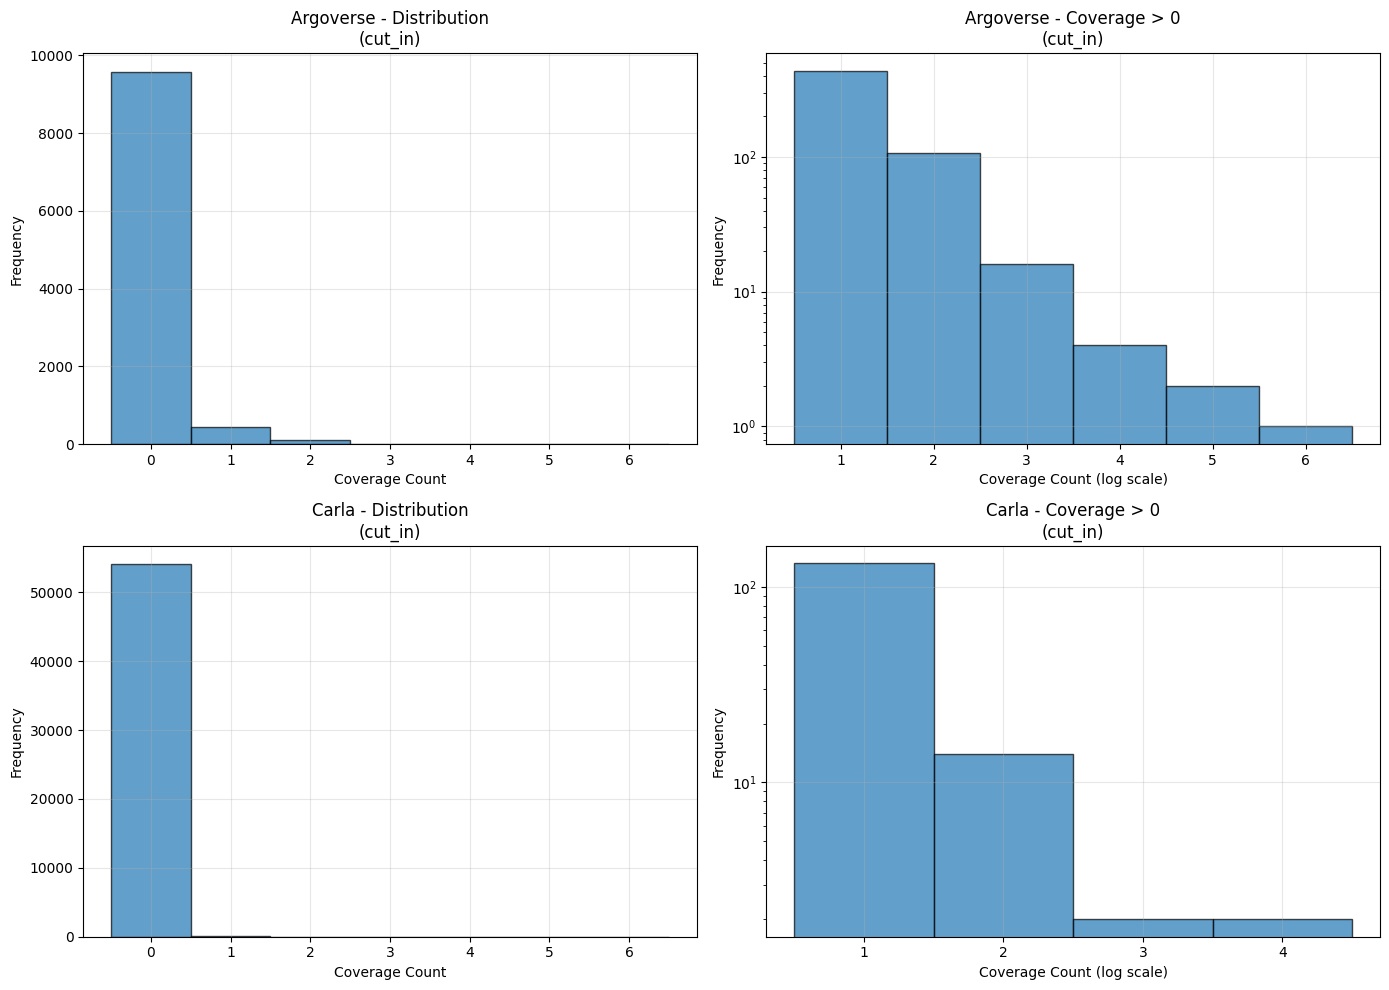

In [ ]:
SUBGRAPH_NAME = "cut_in"

subgraph_df = coverage_df[coverage_df['subgraph_name'] == SUBGRAPH_NAME].copy()
subgraph_df['coverage_count'] = subgraph_df['coverage_count'].astype(int)

# Only plot nodes with coverage > 0
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for idx, dataset in enumerate(['argoverse', 'carla']):
    dataset_df = subgraph_df[subgraph_df['dataset'] == dataset]
    
    non_zero = dataset_df[dataset_df['coverage_count'] > 0]['coverage_count']
    if len(non_zero) > 0:
        max_non_zero = int(non_zero.max())
        bins_non_zero = range(1, max_non_zero + 2)
        axes[idx].hist(non_zero, bins=bins_non_zero, edgecolor='black', alpha=0.7, align='left')
        axes[idx].set_xlabel('Coverage Count')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{dataset.capitalize()} - Coverage > 0\n({SUBGRAPH_NAME})')
        axes[idx].set_yscale('log')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        axes[idx].text(0.5, 0.5, 'No nodes with coverage > 0', 
                    ha='center', va='center', transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()



In [27]:
max_actors = 10

graph_stats = subgraph_df.groupby(['dataset', 'graph_path']).agg({
    'node_id': 'nunique',
    'coverage_count': 'sum'
}).reset_index()
graph_stats.columns = ['dataset', 'graph_path', 'num_actors', 'total_coverage']

graphs_with_few_actors = graph_stats[graph_stats['num_actors'] <= max_actors].copy()
graphs_with_few_actors = graphs_with_few_actors.sort_values('total_coverage', ascending=True)


In [28]:
VISUALIZE_INDEX = 0
selected_row_stats = graphs_with_few_actors.iloc[VISUALIZE_INDEX]
selected_graph_id = selected_row_stats['graph_path']
selected_dataset = selected_row_stats['dataset']

graph_coverage = subgraph_df[subgraph_df['graph_path'] == selected_graph_id].copy()
node_coverage_dict = dict(zip(graph_coverage['node_id'], graph_coverage['coverage_count']))

selected_row = coverage_df[coverage_df['graph_path'] == selected_graph_id].iloc[0]
actor_graph_path = selected_row['actor_graph_path']
timestamp = selected_row['timestamp']


In [29]:
actor_graph_filename = os.path.basename(actor_graph_path)
log_id = actor_graph_filename.replace('_actor_graph.pkl', '')

with open(actor_graph_path, "rb") as f:
    actor_graph = pickle.load(f)

if selected_dataset == 'argoverse':
    dataroot = repo_root / "argoverse_data" / "train"
    scenario, map = get_scenario_data(dataroot, log_id)
else:
    scenario = None
    map = None



following_lead: 2 total edges

leading_vehicle: 0 total edges

neighbor_vehicle: 0 total edges

opposite_vehicle: 6 total edges


/Users/marius/code/graph_coverage/graph_creator/create_graph.py:203: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


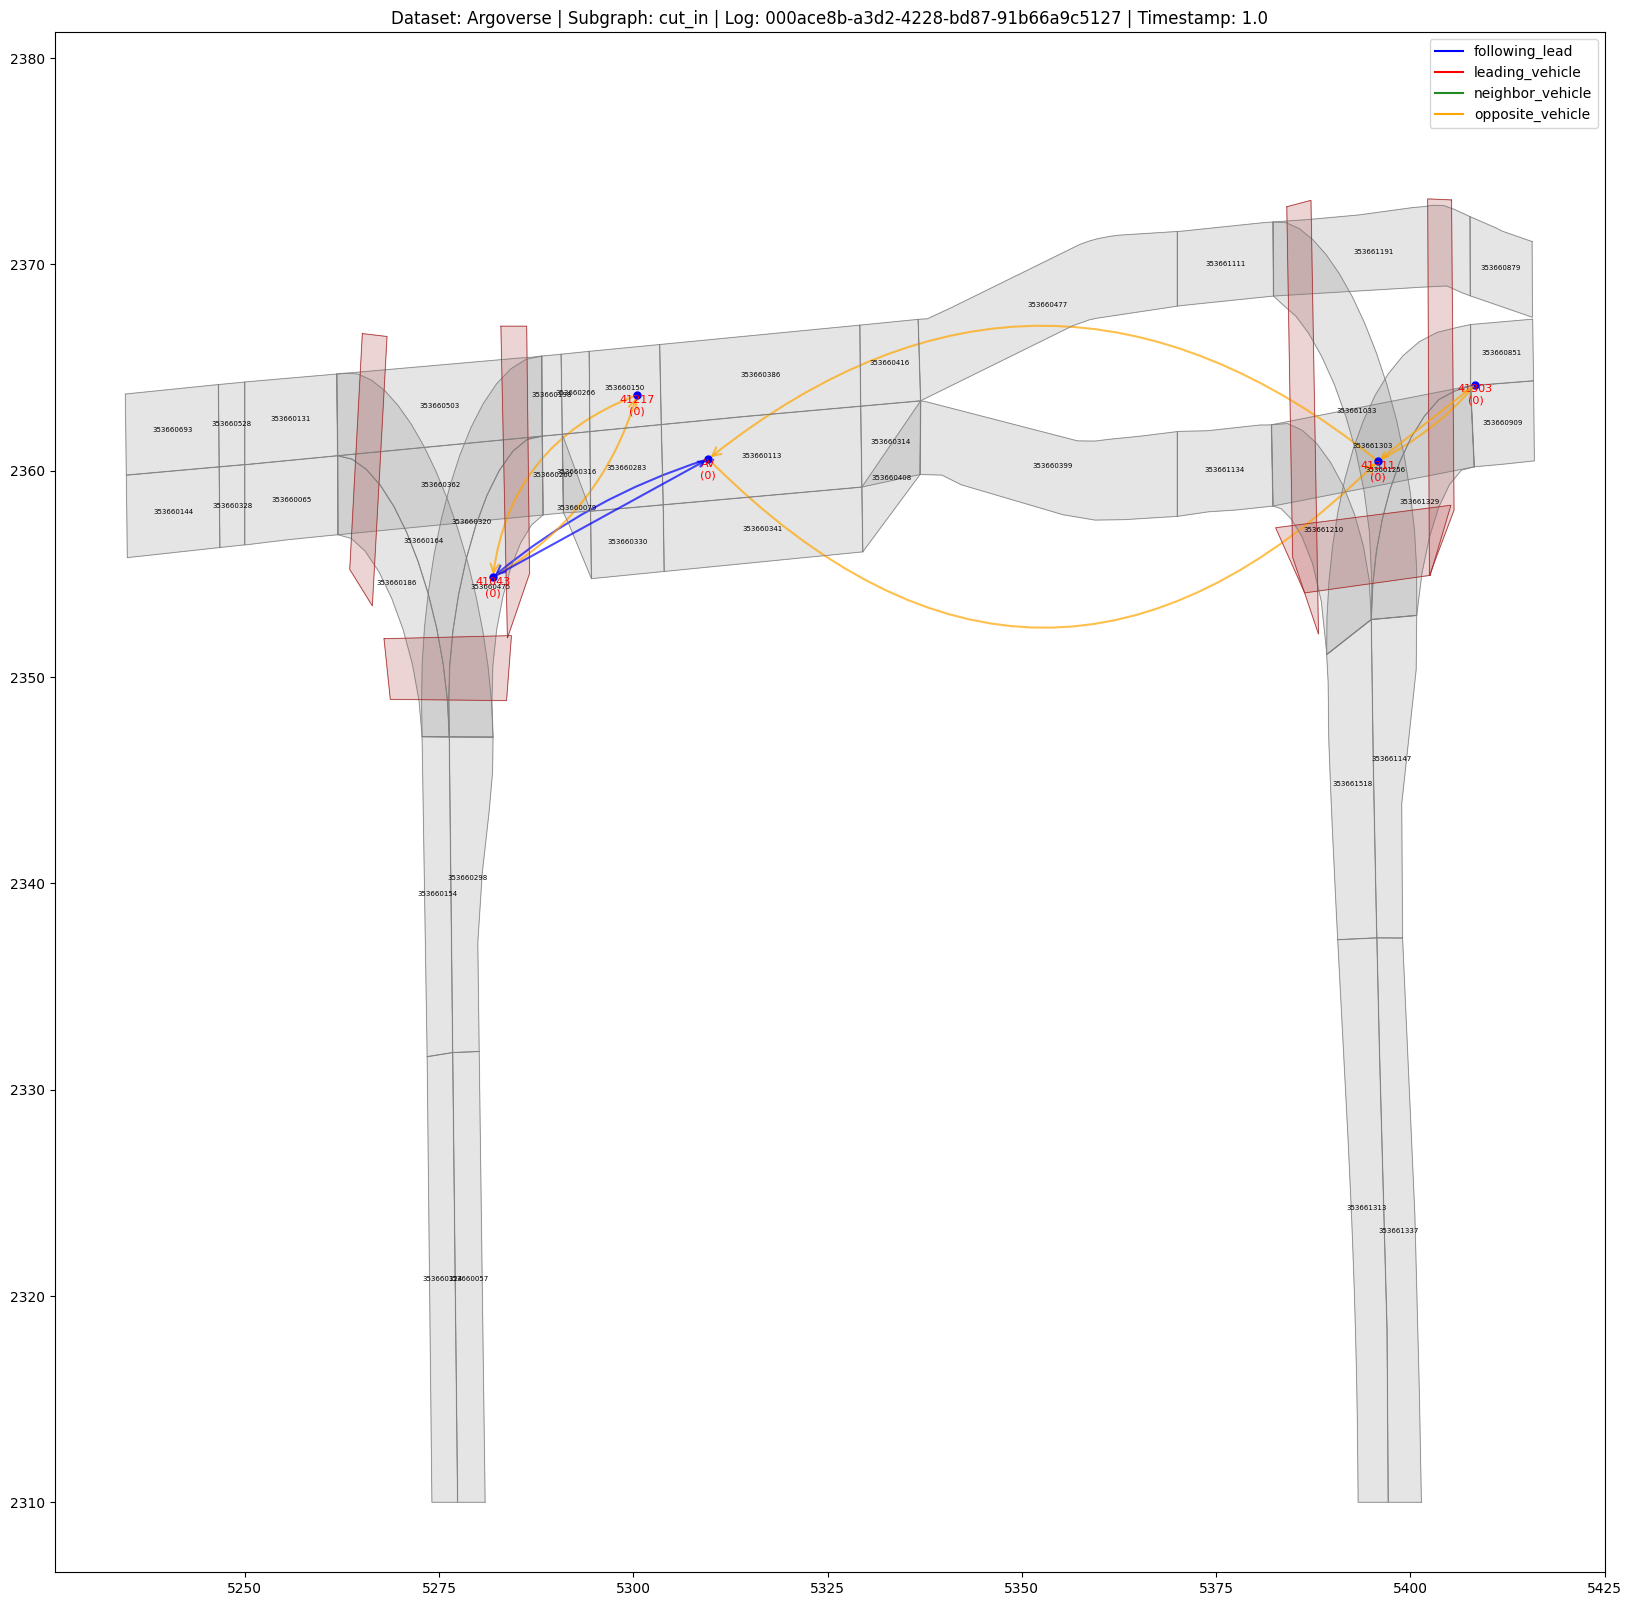

In [30]:
if selected_dataset == 'argoverse' and scenario is not None and map is not None:
    plot_scene_at_timestep(
        scenario, 
        map, 
        timestep=timestamp, 
        actor_graph=actor_graph,
        lane_label=True,
        node_coverage_dict=node_coverage_dict
    )
    plt.title(f"Dataset: {selected_dataset.capitalize()} | Subgraph: {SUBGRAPH_NAME} | Log: {log_id} | Timestamp: {timestamp}")
    plt.show()
else:
    print(f"Cannot visualize CARLA scenes with plot_scene_at_timestep (requires Argoverse format)")
    print(f"Selected: {selected_dataset} dataset, Log: {log_id}, Timestamp: {timestamp}")
